## Ensemble methods

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

data = pd.read_csv('data.csv')
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.571373,66,0,0.430620,9274.0,10,0,1,0,0.0
1,0,0.233999,56,0,0.257380,5656.0,12,0,0,0,0.0
2,0,0.299270,33,0,0.114575,4747.0,8,0,0,0,3.0
3,0,0.032165,41,0,0.308326,8490.0,8,0,1,0,0.0
4,0,0.050591,36,0,0.862627,3333.0,8,0,2,0,0.0


In [3]:
from sklearn.model_selection import train_test_split
y = data['SeriousDlqin2yrs']
X = data.drop(['SeriousDlqin2yrs'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 7)

print('train',X_train.shape,y_train.shape)
print('test',X_test.shape,y_test.shape)

train (3750, 10) (3750,)
test (1250, 10) (1250,)


In [4]:
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from time import time
%matplotlib inline

In [5]:
columns_list = list(X.columns)

In [6]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier(random_state = 14)

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)
predictions_proba = clf.predict_proba(X_test)[:,1]


In [7]:
from sklearn.metrics import confusion_matrix, roc_auc_score
conf_matrix = confusion_matrix(y_test, y_pred)
auroc_score = roc_auc_score(y_test, predictions_proba)
accuracy_score = clf.score(X_test, y_test)

print("Confusion matrix: \n", conf_matrix)
print("AUROC score:", auroc_score)
print("Accuracy score:", accuracy_score)

data = [['Decision Tree Classifier', accuracy_score, auroc_score ]]
df = pd.DataFrame(data, columns=['Algorithm' , 'Accuracy Score', 'AUROC Score'])


Confusion matrix: 
 [[1090   75]
 [  65   20]]
AUROC score: 0.5854582176218127
Accuracy score: 0.888


In [8]:
X_train.columns

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [9]:
bg = BaggingClassifier(base_estimator=clf, n_estimators = 25, random_state= 14)
bg.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = bg.predict(X_test)
predictions_proba = bg.predict_proba(X_test)[:,1]

In [10]:
conf_matrix = confusion_matrix(y_test, y_pred)
auroc_score = roc_auc_score(y_test, predictions_proba)
accuracy_score = bg.score(X_test, y_test)

print("Confusion matrix: \n", conf_matrix)
print("AUROC score:", auroc_score)
print("Accuracy score:", accuracy_score)

df = df.append({'Algorithm':'Bagging Classifier', 'Accuracy Score':accuracy_score, 'AUROC Score':auroc_score}, ignore_index=True)


Confusion matrix: 
 [[1146   19]
 [  74   11]]
AUROC score: 0.7857106791214341
Accuracy score: 0.9256


In [11]:
warnings.simplefilter(action='ignore', category=FutureWarning)

rf_model = RandomForestClassifier()

# Find the best parameters for the random forest

param_grid = {"n_estimators": [1, 10, 50, 100],
              "max_features": [1, 5, 10, "auto"],
              "criterion": ['gini','entropy'],
              "random_state": [17]}

# Grid search

clf_rf_model = GridSearchCV(rf_model, param_grid=param_grid)
clf_rf_model.fit(X_train, y_train)
clf_rf_model.best_params_

{'criterion': 'entropy',
 'max_features': 1,
 'n_estimators': 100,
 'random_state': 17}

In [12]:
# fit the model with the best parameters on the data
cv_rf_model = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', max_features = 1,
                                     random_state = 17)
cv_rf_model.fit(X_train, y_train)

# predictions
predictions_class = cv_rf_model.predict(X_test)
predictions_proba = cv_rf_model.predict_proba(X_test)[:,1]

## Reporting AUROC score and confusion matrix

In [13]:
conf_matrix = confusion_matrix(y_test, predictions_class)
auroc_score = roc_auc_score(y_test, predictions_proba)
accuracy_score = cv_rf_model.score(X_test,y_test)

print("Confusion matrix:", conf_matrix)
print("AUROC score:", auroc_score)

df = df.append({'Algorithm':'Random Forest Classifier', 'Accuracy Score':accuracy_score, 'AUROC Score':auroc_score}, ignore_index=True)

Confusion matrix: [[1162    3]
 [  82    3]]
AUROC score: 0.8375612219136582


In [14]:
ada_boost = AdaBoostClassifier()


# Grid search
from sklearn.model_selection import GridSearchCV

grid_search_ada_boost = GridSearchCV(ada_boost, {"n_estimators":[10, 100], "learning_rate":[0.01, 0.1, 0.5]})

grid_search_ada_boost.fit(X_train, y_train)
grid_search_ada_boost.best_params_
          

{'learning_rate': 0.1, 'n_estimators': 100}

In [15]:
# fit the model with the best parameters on the data
cv_ab_model = AdaBoostClassifier(n_estimators = 100, learning_rate = 0.1)
cv_ab_model.fit(X_train, y_train)

# predictions
predictions_class = cv_ab_model.predict(X_test)
predictions_proba = cv_ab_model.predict_proba(X_test)[:,1]

## Report the AUROC score and confusion matrix

In [16]:
conf_matrix = confusion_matrix(y_test, predictions_class)
auroc_score = roc_auc_score(y_test, predictions_proba)
accuracy_score = cv_ab_model.score(X_test,y_test)

print("Confusion matrix: \n", conf_matrix)
print("AUROC score:", auroc_score)

df = df.append({'Algorithm':'AdaBoost Classifier', 'Accuracy Score':accuracy_score, 'AUROC Score':auroc_score}, ignore_index=True)


Confusion matrix: 
 [[1153   12]
 [  72   13]]
AUROC score: 0.8390254986114618


In [17]:
grad_boost = GradientBoostingClassifier()


# Grid search
grid_search_grad_boost = GridSearchCV(grad_boost, {"n_estimators":[10, 100], "learning_rate":[0.01, 0.1, 0.5]})

grid_search_grad_boost.fit(X_train, y_train)
grid_search_grad_boost.best_params_

{'learning_rate': 0.1, 'n_estimators': 10}

In [18]:
# fit the model with the best parameters on the data
cv_gb_model = GradientBoostingClassifier(n_estimators = 10, learning_rate = 0.1,)
cv_gb_model.fit(X_train, y_train)

# predictions
predictions_class = cv_gb_model.predict(X_test)
predictions_proba = cv_gb_model.predict_proba(X_test)[:,1]

## Report the AUROC score and confusion matrix

In [19]:
conf_matrix = confusion_matrix(y_test, predictions_class)
auroc_score = roc_auc_score(y_test, predictions_proba)
accuracy_score = cv_gb_model.score(X_test,y_test)

print("Confusion matrix: \n", conf_matrix)
print("AUROC score:", auroc_score)

df = df.append({'Algorithm':'GradientBoosting Classifier', 'Accuracy Score':accuracy_score, 'AUROC Score':auroc_score}, ignore_index=True)


Confusion matrix: 
 [[1164    1]
 [  84    1]]
AUROC score: 0.8366372128250441


In [1]:
df

NameError: name 'df' is not defined

1) AdaBoost have the better accuracy and maximum ROC score among three ensemble models ,hence performs the best.It also performs better then Gradient Model Boosting which can be accounted to overfitting of Gradient Boosting Model

2) Decision Tree has the worst roc score due to the basic nature of the classifier and it's inability to handle complex data as well as imbalanced data

3) Ensemble models have slightly better accuracy scores than decision tree. The reason for this is imbalance in the dataset

4) Bagging classifiers perform slightly worse than boosting algorithms and random forests. This may be due to the non-random nature of bagging splits, which may not be able to handle the complexity encountered in the test data set.

## XGBoost on Datasets with varying Class Imbalance [15 points]


In [21]:
from sklearn.model_selection import train_test_split
import pandas as pd

dataset = pd.read_csv("data_equally_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Balanced Dataset")
# Number of classes in training Data
print(y_train1.value_counts())
# Number of classes in test Data
print(y_test1.value_counts())

dataset = pd.read_csv("data_originally_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Originally Imbalanced Dataset")
# Number of classes in training Data
print(y_train2.value_counts())
# Number of classes in test Data
print(y_test2.value_counts())

dataset = pd.read_csv("data_highly_biased_final.csv")
X = dataset.drop(['SeriousDlqin2yrs'], axis=1)
y = dataset['SeriousDlqin2yrs']
X_train3, X_test3, y_train3, y_test3 = train_test_split(X, y, test_size = 0.2, random_state = 15, stratify = y)
print("Highly Imbalanced Dataset")
# Number of classes in training Data
print(y_train3.value_counts())
# Number of classes in test Data
print(y_test3.value_counts())

Balanced Dataset
0    4000
1    4000
Name: SeriousDlqin2yrs, dtype: int64
0    1000
1    1000
Name: SeriousDlqin2yrs, dtype: int64
Originally Imbalanced Dataset
0    7466
1     534
Name: SeriousDlqin2yrs, dtype: int64
0    1866
1     134
Name: SeriousDlqin2yrs, dtype: int64
Highly Imbalanced Dataset
0    7800
1     200
Name: SeriousDlqin2yrs, dtype: int64
0    1950
1      50
Name: SeriousDlqin2yrs, dtype: int64


In [22]:
import matplotlib.pyplot as plt
from sklearn.model_selection import (train_test_split,GridSearchCV)
from sklearn.metrics import (accuracy_score,roc_auc_score)
from sklearn.ensemble import (RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier)
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from time import time
import xgboost

%matplotlib inline

In [23]:
# Using the earlier dataset and applying XGBoost on it

clf = xgboost.XGBClassifier()

param_grid = {"n_estimators": [10, 100],
          "learning_rate": [0.01, 0.1, 0.5],
          "random_state": [17]
          }

# Grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)

# Balanced Dataset
print("Balanced Dataset")
grid_search.fit(X_train1, y_train1)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train1, y_train1)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt1 = clf.predict(X_test1)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: \n")
print(confusion_matrix(y_test1, y_pred_gbt1))

y_pred_proba1 = clf.predict_proba(X_test1)[:,1]

acc_score = accuracy_score(y_test1,y_pred_gbt1)
auc_score = roc_auc_score(y_test1,y_pred_proba1)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))


# Originally Imbalanced Dataset

print("Originally Imbalanced Dataset")
grid_search.fit(X_train2, y_train2)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train2, y_train2)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt2 = clf.predict(X_test2)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: ")
print(confusion_matrix(y_test2, y_pred_gbt2))

y_pred_proba2 = clf.predict_proba(X_test2)[:,1]

acc_score = accuracy_score(y_test2,y_pred_gbt2)
auc_score = roc_auc_score(y_test2,y_pred_proba2)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))

# Highly Imalanced Dataset

print("Highly Imbalanced Dataset")
grid_search.fit(X_train3, y_train3)
print(grid_search.best_params_)
clf.set_params(**grid_search.best_params_)

t0 = time()
clf.fit(X_train3, y_train3)
print("training time", round(time()-t0, 3), "s")

t0 = time()
y_pred_gbt3 = clf.predict(X_test3)
print("predict time", round(time()-t0, 3), "s")

print("XGBoost conf matrix: ")
print(confusion_matrix(y_test3, y_pred_gbt3))

y_pred_proba3 = clf.predict_proba(X_test3)[:,1]

acc_score = accuracy_score(y_test3,y_pred_gbt3)
auc_score = roc_auc_score(y_test3,y_pred_proba3)
print("Accuracy: {}\n AUC_ROC: {}\n".format(acc_score,auc_score))

Balanced Dataset
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 17}
training time 0.337 s
predict time 0.004 s
XGBoost conf matrix: 

[[794 206]
 [228 772]]
Accuracy: 0.783
 AUC_ROC: 0.856863

Originally Imbalanced Dataset
{'learning_rate': 0.1, 'n_estimators': 100, 'random_state': 17}
training time 0.301 s
predict time 0.003 s
XGBoost conf matrix: 
[[1843   23]
 [ 114   20]]
Accuracy: 0.9315
 AUC_ROC: 0.8342691686263217

Highly Imbalanced Dataset
{'learning_rate': 0.01, 'n_estimators': 100, 'random_state': 17}
training time 0.303 s
predict time 0.004 s
XGBoost conf matrix: 
[[1945    5]
 [  50    0]]
Accuracy: 0.9725
 AUC_ROC: 0.8398564102564102



In [24]:
y_pred_proba1

array([0.37664905, 0.94573927, 0.28498152, ..., 0.25596365, 0.50865114,
       0.98366356], dtype=float32)

Text(0.5, 0.98, 'Calibration plots (XGBoost) - Uniform')

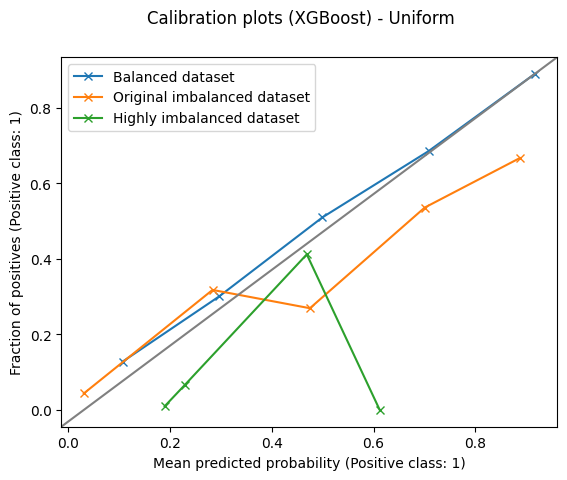

In [25]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots()

# Plot all calibration curves for strategy = 'uniform' (It is uniform by default)
xg1_y, xg1_x = calibration_curve(y_test1, y_pred_proba1)
xg2_y, xg2_x = calibration_curve(y_test2, y_pred_proba2)
xg3_y, xg3_x = calibration_curve(y_test3, y_pred_proba3)

plt.plot(xg1_x, xg1_y, marker='x', label='Balanced dataset')
plt.plot(xg2_x, xg2_y, marker='x', label='Original imbalanced dataset')
plt.plot(xg3_x, xg3_y, marker='x', label='Highly imbalanced dataset')

# Reference line
line = mlines.Line2D([0, 1], [0, 1], color='grey')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.set_xlabel('Mean predicted probability (Positive class: 1)')
ax.set_ylabel('Fraction of positives (Positive class: 1)')
plt.legend(loc='best')
fig.suptitle('Calibration plots (XGBoost) - Uniform')

Text(0.5, 0.98, 'Calibration plots (XGBoost) - Quantile')

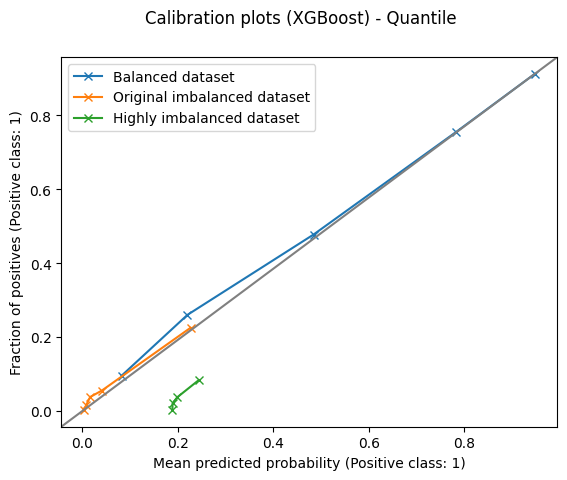

In [26]:
# Plot all calibration curves for strategy = 'quantile'
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

fig, ax = plt.subplots()

# Plot all calibration curves for strategy = 'uniform' (It is uniform by default)
xg1_y, xg1_x = calibration_curve(y_test1, y_pred_proba1, strategy='quantile')
xg2_y, xg2_x = calibration_curve(y_test2, y_pred_proba2, strategy='quantile')
xg3_y, xg3_x = calibration_curve(y_test3, y_pred_proba3, strategy='quantile')

plt.plot(xg1_x, xg1_y, marker='x', label='Balanced dataset')
plt.plot(xg2_x, xg2_y, marker='x', label='Original imbalanced dataset')
plt.plot(xg3_x, xg3_y, marker='x', label='Highly imbalanced dataset')

# Reference line
line = mlines.Line2D([0, 1], [0, 1], color='grey')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.set_xlabel('Mean predicted probability (Positive class: 1)')
ax.set_ylabel('Fraction of positives (Positive class: 1)')
plt.legend(loc='best')
fig.suptitle('Calibration plots (XGBoost) - Quantile')

**Observing how the plots look:** 

In general, as the datasets become more imbalanced, the curve has more variance around the diagonal/shift away from the diagonal. For the uniform strategy, the bins have identical lengths, whereas in the quantile strategy, the bins are stratified such that there are equal number of observations in each bin, and depend on the predicted probabilities. For the equally biased dataset in both strategies, the curve is quite close to the diagonal. For the originally imbalanced dataset, in the uniform strategy, the fit seems to be poor and deviates from the diagonal quite a lot in the last few bins whereas in the quantile dataset the fit hugs the diagonal quite well. The fit is very poor in the highly imbalanced dataset in both cases, and furthermore 1 out of the 5 bins are empty.

**For which dataset is the model calibrated the best?**

The model is calibrated the best for the equally biased dataset

**Which of the binning strategies provide more informative visualization for each of the datasets?**

* For the equally biased dataset, both of the strategies produce quite a good fit, both equally informative.
* For the originally imbalanced dataset, the uniform strategy produces a more informative visualization, because in the uniform strategy, it gives us information about the high probability points, even if there are very few of them, and this sways the graph away from the diagonal by a lot. It's easier to gauge calibration with the uniform plot for this case.
* For the highly imbalanced dataset, both fits are bad, but the quantile method is more accurate because it approximately ensures there are equal number of points in each bin, so we can be relatively more confident in our mean probability estimates.